# Load Samples

In [20]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.ticker import MaxNLocator
import numpy as np
import csv
import ast
from dataclasses import dataclass, fields
from typing import Type, TypeVar
from pathlib import Path
from typing import Union, List, Optional, Dict
from scipy import stats
from sklearn import preprocessing
from sklearn.metrics import r2_score
import seaborn as sns
import pandas as pd
from scipy.stats import shapiro
import pingouin as pg
import os

alpha = 0.05

notebook_path = os.path.abspath("Sensitivity-Analysis-public.ipynb")
csv_path = os.path.join(os.path.dirname(notebook_path), "reviews-public-data.csv")
data = pd.read_csv(csv_path, delimiter=';')

# Perform Sensitivity Analysis

In [21]:
problem = {
    'num_vars': 12,  
    'names': ['score_LEN', 'score_COM', 'score_CLI', 'score_COC', 'score_ANF', 
              'score_UNF', 'score_ACF', 'score_UCF', 'score_RCF', 'score_RNF', 
              'score_CHF', 'score_CEN'],
    'bounds': [
        [0, 1],
        [0, 1],
        [0, 1],
        [-1, 1],
        [0, 1],
        [0, 1],
        [0, 1],
        [0, 1],
        [0, 1],
        [0, 1],
        [0, 1],
        [0, 1]
        ]
}

In [22]:
def model(scores):
    # Weights as depicted in Table III and explained in Section IV-D
    weights = {
        'score_LEN': 1,
        'score_COM': 1,
        'score_CLI': 2,
        'score_COC': 2,
        'score_ANF': 2,
        'score_UNF': 1,
        'score_ACF': 4,
        'score_UCF': 2,
        'score_RCF': -2,
        'score_RNF': -1,
        'score_CHF': -1,
        'score_CEN': 2
    }
    
    # Calculate the risk score by summing up the score values multiplied by their respective weights (see Sec. III-D)
    risk_score = (
        scores[0] * weights['score_LEN'] +
        scores[1] * weights['score_COM'] +
        scores[2] * weights['score_CLI'] +
        scores[3] * weights['score_COC'] +
        scores[4] * weights['score_ANF'] +
        scores[5] * weights['score_UNF'] +
        scores[6] * weights['score_ACF'] +
        scores[7] * weights['score_UCF'] +
        scores[8] * weights['score_RCF'] +
        scores[9] * weights['score_RNF'] +
        scores[10] * weights['score_CHF'] +
        scores[11] * weights['score_CEN']
    )
    
    return risk_score

In [23]:
from SALib.sample import saltelli
from SALib.analyze import sobol

# Generate samples
samples = saltelli.sample(problem, 2039 * (12 + 2))  # following a common rule of thumb: use N x (2D + 2) model exaluations with sample size N=2039 sample and number of parameters D=12

# Run model
Y = np.array([model(scores) for scores in samples])

# Perform Sobol sensitivity analysis (well-fitting for mediocre model sizes, more accurate than some alternatives in our context)
Si = sobol.analyze(problem, Y)

C:\Users\haas\AppData\Local\Temp\ipykernel_38764\1254852360.py:5: DeprecationWarning: `salib.sample.saltelli` will be removed in SALib 1.5.1 Please use `salib.sample.sobol`
  samples = saltelli.sample(problem, 2039 * (12 + 2))  # following a common rule of thumb: use N x (2D + 2) model exaluations with sample size N=2039 sample and number of parameters D=12
C:\Users\haas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\SALib\sample\saltelli.py:110: UserWarning: 
        Convergence properties of the Sobol' sequence is only valid if
        `N` (28546) is equal to `2^n`.
        
  warnings.warn(msg)
C:\Users\haas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\SALib\util\__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  n

In [24]:
original_s1 = Si['S1'] # First-order sensitivity indices
original_sT = Si['ST'] # Total-order sensitivity indices

print(original_s1)  
print(original_sT)  

[0.01749688 0.01756766 0.07027486 0.28054805 0.07018884 0.01755513
 0.28079842 0.07017673 0.07016712 0.01753882 0.01753655 0.07010593]
[0.01754423 0.01754279 0.07017665 0.28071047 0.07018878 0.01754367
 0.28070332 0.07017785 0.07017519 0.01754414 0.01754232 0.07016162]


--> `score_COC` and `score_ACF` have the highest first-order indices, i.e., these scores are key drivers of the risk score in the model.

--> `score_LEN`, `score_COM`, `score_ANF`, `score_RNF`, `score_CHF` have much lower indices, indicating that individually, they have minimal impact on the risk score when all other factors remain constant.

# Scenario Analyses

## Helpers

In [25]:
def print_stats(test_gaps_by_assessments):
    print('Total number of assessments: %.0f' % len(test_gaps_by_assessments))

    risky_test_gaps = 0
    safe_test_gaps = 0

    relative_ranks_risky_gaps = []
    relative_ranks_safe_gaps = []

    project_test_gaps = {}
    project_risky_test_gaps = {}
    project_assessments = {}

    for assessment in test_gaps_by_assessments:
        for test_gap in assessment.test_gaps:
            if test_gap.test_gap_assessment == "risky":
                risky_test_gaps += 1
            elif test_gap.test_gap_assessment == "safe":
                safe_test_gaps += 1
            else:
                raise ValueError('The test_gap_assessment must be either \'risky\' or \'safe\' but was', test_gap["test_gao_assessment"])
    
    total_test_gaps = risky_test_gaps+safe_test_gaps
    print('Total number of test gaps: %.0f' % total_test_gaps)
    print('Safe test gaps: %.0f' % safe_test_gaps)
    print('Risky test gaps: %.0f' % risky_test_gaps)
    scaled_risky_ranks = []
    scaled_safe_ranks = []
    
    assessment_scores = []
    all_risk_scores = []
    
    for assessment in test_gaps_by_assessments:
    
        number_of_risky_gaps = 0
        number_of_gaps = len(assessment.test_gaps)
        assessment_risk_scores = []
        ranks_risky_gaps = []
        ranks_safe_gaps = []
        
        for test_gap in assessment.test_gaps:
            assessment_scores.append(test_gap.assessment_score)
            all_risk_scores.append(test_gap.risk_score)
            assessment_risk_scores.append(test_gap.risk_score)
            number_of_risky_gaps += test_gap.assessment_score
    
        number_of_safe_gaps = number_of_gaps - number_of_risky_gaps
        
        ranks = stats.rankdata(np.array(assessment_risk_scores) * -1 ) # ranking assumes lowest number to be best => multiply by  -1
        zipped = dict(zip(assessment_risk_scores, ranks))

        if assessment.project in project_test_gaps:
            project_test_gaps[assessment.project] = project_test_gaps[assessment.project] + number_of_gaps
            project_risky_test_gaps[assessment.project] = project_risky_test_gaps[assessment.project] + number_of_risky_gaps
            project_assessments[assessment.project] = project_assessments[assessment.project] + 1
        else:
            project_test_gaps[assessment.project] = number_of_gaps
            project_risky_test_gaps[assessment.project] = number_of_risky_gaps
            project_assessments[assessment.project] = 1
            
    
        for test_gap in assessment.test_gaps:
            if test_gap.assessment_score == 1:
                ranks_risky_gaps.append(zipped[test_gap.risk_score])
                relative_ranks_risky_gaps.append((zipped[test_gap.risk_score]-1)/(number_of_gaps-1))
            else:
                ranks_safe_gaps.append(zipped[test_gap.risk_score])
                relative_ranks_safe_gaps.append((zipped[test_gap.risk_score]-1)/(number_of_gaps-1))
        
        if( number_of_risky_gaps == 0):
            scaled_risky_rank = 1.0
        elif(number_of_safe_gaps == 0):
            scaled_risky_rank = 0.0
        else:
            best_possible_ranking = (number_of_risky_gaps * (number_of_risky_gaps + 1)) / (2 * number_of_risky_gaps * number_of_gaps)
            worst_possible_ranking = - (number_of_risky_gaps - 2 * number_of_gaps - 1) / (2 * number_of_gaps)
        
            sum_ranks_risky_gaps = sum(ranks_risky_gaps)
            scaled_risky_rank = (( sum_ranks_risky_gaps / (number_of_risky_gaps * ( number_of_gaps))) - best_possible_ranking) / (worst_possible_ranking - best_possible_ranking) # min-max scaling
        
        scaled_risky_ranks.append(scaled_risky_rank)
    
        if( number_of_safe_gaps == 0):
            scaled_safe_rank = 0.0
        elif(number_of_risky_gaps == 0):
            scaled_safe_rank = 1.0
        else:
            best_possible_ranking = (number_of_safe_gaps * (number_of_safe_gaps + 1)) / (2 * number_of_safe_gaps * number_of_gaps)
            worst_possible_ranking = - (number_of_safe_gaps - 2 * number_of_gaps - 1) / (2 * number_of_gaps)
            sum_ranks_safe_gaps = sum(ranks_safe_gaps)
            scaled_safe_rank = (( sum_ranks_safe_gaps / (number_of_safe_gaps * ( number_of_gaps))) - best_possible_ranking) / (worst_possible_ranking - best_possible_ranking) # min-max scaling
        scaled_safe_ranks.append(scaled_safe_rank)
    
    return scaled_risky_ranks, scaled_safe_ranks, relative_ranks_risky_gaps, relative_ranks_safe_gaps

T = TypeVar('T', bound='GenericRecord')

class GenericRecord:
    """ Generic base class for transforming dataclasses. """
    @classmethod
    def _transform(cls: Type[T], dict_: dict) -> dict:
        """ Convert string values in given dictionary to corresponding type. """
        return {field.name: cls._transform_field(field, dict_[field.name])
                    for field in fields(cls)}
    
    @classmethod
    def _transform_field(cls: Type[T], field, value):
        if field.type is float:
            return float(value.replace(',', '.'))
        return field.type(value)


@dataclass
class CSV_Record(GenericRecord):
    """ Define the fields and their types in a record.
        Field names must match column names in CSV file header.
    """
    project: str
    month: str
    test_gap_assessment: str
    risk_score: float
    score_LEN: float
    score_COM: float
    score_CLI: float
    score_COC: float
    score_ANF: float
    score_UNF: float
    score_ACF: float
    score_UCF: float
    score_RCF: float
    score_RNF: float
    score_CHF: float
    score_CEN: float

class Test_Gap:
    def __init__(self, test_gap_assessment, risk_score):
        self.test_gap_assessment = test_gap_assessment
        self.risk_score = risk_score

        if test_gap_assessment == "risky":
            self.assessment_score = 1
        elif test_gap_assessment == "safe":
            self.assessment_score = 0
        else:
            self.assessment_score = -1

    def __str__(self):
        return f'Test_Gap()'


class Assessment:

    def __init__(self, project, month, test_gaps):
        self.project = project
        self.month = month
        self.test_gaps = test_gaps

    def __str__(self):
        return f'Assessment({self.project}-{self.month})'

def read_csv_and_get_test_gaps_scen(filename, model_function):
    records = []

    with open(filename, 'r', newline='', encoding='latin') as file:
        for i, row in enumerate(csv.DictReader(file, delimiter = ';', quoting=csv.QUOTE_MINIMAL)):
            records.append(CSV_Record._transform(row))
    
    previous_project = ""
    previous_month = ""
    current_project = ""
    current_month = ""

    test_gaps_by_assessments = []

    test_gaps_of_assessment = []

    for record in records:
        current_project = record["project"]
        current_month = record["month"]
        test_gap = Test_Gap(record["test_gap_assessment"], model_function([
            record['score_LEN'],
            record['score_COM'],
            record['score_CLI'],
            record['score_COC'],
            record['score_ANF'],
            record['score_UNF'],
            record['score_ACF'],
            record['score_UCF'],
            record['score_RCF'],
            record['score_RNF'],
            record['score_CHF'],
            record['score_CEN']
        ]))
        if current_project == previous_project and current_month == previous_month:
            test_gaps_of_assessment.append(test_gap)
        else:
            if previous_project != "":
                test_gaps_by_assessments.append(Assessment(previous_project,previous_month,test_gaps_of_assessment))
            previous_project=current_project
            previous_month=current_month

            test_gaps_of_assessment = []
            test_gaps_of_assessment.append(test_gap)
    test_gaps_by_assessments.append(Assessment(previous_project,previous_month,test_gaps_of_assessment))

    return test_gaps_by_assessments

# From https://gist.github.com/ihincks/6a420b599f43fcd7dbd79d56798c4e5a#file-lighten_color-py
def lighten_color(color, amount=0.5):
    """
    Lightens the given color by multiplying (1-luminosity) by the given amount.
    Input can be matplotlib color string, hex string, or RGB tuple.

    Examples:
    >> lighten_color('g', 0.3)
    >> lighten_color('#F034A3', 0.6)
    >> lighten_color((.3,.55,.1), 0.5)
    """
    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], max(0, min(1, amount * c[1])), c[2])


def draw_ranking_kdp(scaled_risky_ranks,scaled_safe_ranks):
    
    sns.set(style="whitegrid")

    colors = sns.color_palette('Set1')

    risky_color = lighten_color(colors[0], 1.3)
    safe_color = lighten_color(colors[1], 0.7)

    plt.figure(figsize=(8,4))

    ax = sns.histplot({'Risky': scaled_risky_ranks, 'Safe': scaled_safe_ranks}, kde=True,
                      kde_kws={'bw_adjust': 0.4}, multiple='layer', binwidth=0.1,  
                      palette={'Risky': risky_color, 'Safe': safe_color})

    median_risky = np.median(scaled_risky_ranks)
    median_safe = np.median(scaled_safe_ranks)

    # Add median lines
    plt.axvline(median_risky, color=risky_color, linestyle='--') 
    plt.axvline(median_safe, color=safe_color, linestyle='--') 

    # Create legend patches
    patch1 = mpatches.Patch(color=risky_color, label=f'Risky (median: {median_risky:.2f})')
    patch2 = mpatches.Patch(color=safe_color, label=f'Less risky (median: {median_safe:.2f})')
    plt.legend(handles=[patch1, patch2], fontsize=20)

    ax.yaxis.set_major_locator(MaxNLocator(integer=True))

    plt.xlabel('Relative rankings of test gaps', fontsize=20) 
    plt.ylabel('Density', fontsize=20) 
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)

    # Add annotations for best and worst
    ax.annotate('Best\nrank', xy=(0.045, -0.25), xycoords='axes fraction', ha='center', va='center', fontsize=18)
    ax.annotate('Worst\nrank', xy=(0.95, -0.25), xycoords='axes fraction', ha='center', va='center', fontsize=18)

    plt.tight_layout()

## Scenario 1: Halfing Weights for `score_COC` and `score_ACF`

Total number of assessments: 31
Total number of test gaps: 2039
Safe test gaps: 1858
Risky test gaps: 181


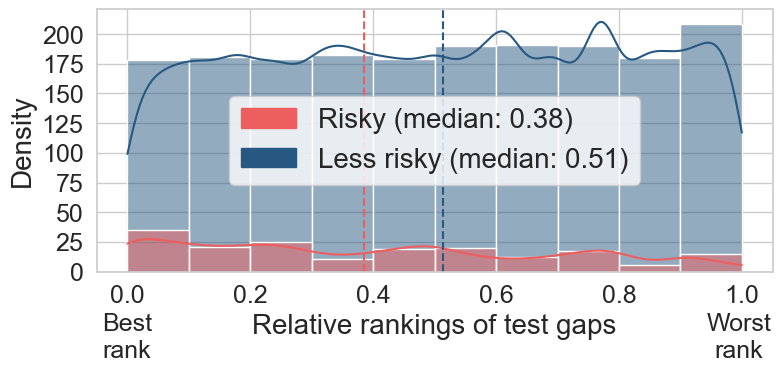

In [26]:
from SALib.sample import saltelli
from SALib.analyze import sobol

def model_scen_1(scores):
    weights = {
        'score_LEN': 1,     # used to be 1
        'score_COM': 1,     # used to be 1
        'score_CLI': 2,     # used to be 2
        'score_COC': 1,     # used to be 2 (halfed)
        'score_ANF': 2,     # used to be 2
        'score_UNF': 1,     # used to be 1
        'score_ACF': 2,     # used to be 4 (halfed)
        'score_UCF': 2,     # used to be 2
        'score_RCF': -2,    # used to be -2
        'score_RNF': -1,    # used to be -1
        'score_CHF': -1,    # used to be -1
        'score_CEN': 2      # used to be 2
    }
    
    # Calculate the risk score by summing up the score values multiplied by their respective weights
    risk_score = (
        scores[0] * weights['score_LEN'] +
        scores[1] * weights['score_COM'] +
        scores[2] * weights['score_CLI'] +
        scores[3] * weights['score_COC'] +
        scores[4] * weights['score_ANF'] +
        scores[5] * weights['score_UNF'] +
        scores[6] * weights['score_ACF'] +
        scores[7] * weights['score_UCF'] +
        scores[8] * weights['score_RCF'] +
        scores[9] * weights['score_RNF'] +
        scores[10] * weights['score_CHF'] +
        scores[11] * weights['score_CEN']
    )
    
    return risk_score

test_gaps_by_assessments = read_csv_and_get_test_gaps_scen(csv_path, model_scen_1)
scaled_risky_ranks, scaled_safe_ranks, relative_ranks_risky_gaps, relative_ranks_safe_gaps = print_stats(test_gaps_by_assessments)
draw_ranking_kdp(relative_ranks_risky_gaps,relative_ranks_safe_gaps)

--> Ranking performance gets worse.

## Scenario 2: Doubling Weights for `score_COC` and `score_ACF`

Total number of assessments: 31
Total number of test gaps: 2039
Safe test gaps: 1858
Risky test gaps: 181


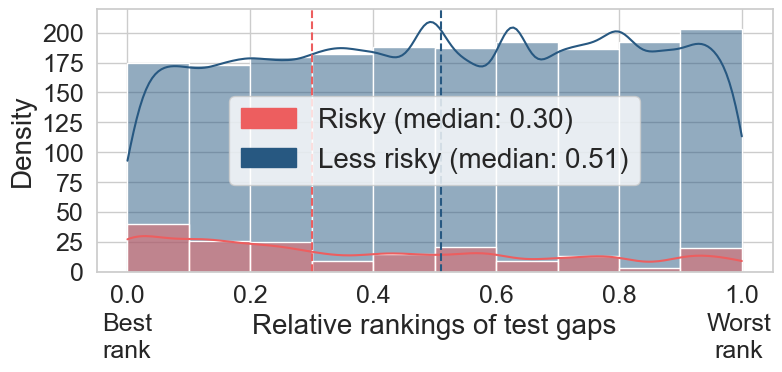

In [27]:
from SALib.sample import saltelli
from SALib.analyze import sobol

def model_scen_2(scores):
    weights = {
        'score_LEN': 1,     # used to be 1
        'score_COM': 1,     # used to be 1
        'score_CLI': 2,     # used to be 2
        'score_COC': 4,     # used to be 2 (doubled)
        'score_ANF': 2,     # used to be 2
        'score_UNF': 1,     # used to be 1
        'score_ACF': 8,     # used to be 4 (doubled)
        'score_UCF': 2,     # used to be 2
        'score_RCF': -2,    # used to be -2
        'score_RNF': -1,    # used to be -1
        'score_CHF': -1,    # used to be -1
        'score_CEN': 2      # used to be 2
    }
    
    # Calculate the risk score by summing up the score values multiplied by their respective weights
    risk_score = (
        scores[0] * weights['score_LEN'] +
        scores[1] * weights['score_COM'] +
        scores[2] * weights['score_CLI'] +
        scores[3] * weights['score_COC'] +
        scores[4] * weights['score_ANF'] +
        scores[5] * weights['score_UNF'] +
        scores[6] * weights['score_ACF'] +
        scores[7] * weights['score_UCF'] +
        scores[8] * weights['score_RCF'] +
        scores[9] * weights['score_RNF'] +
        scores[10] * weights['score_CHF'] +
        scores[11] * weights['score_CEN']
    )
    
    return risk_score

test_gaps_by_assessments = read_csv_and_get_test_gaps_scen(csv_path, model_scen_2)
scaled_risky_ranks, scaled_safe_ranks, relative_ranks_risky_gaps, relative_ranks_safe_gaps = print_stats(test_gaps_by_assessments)
draw_ranking_kdp(relative_ranks_risky_gaps,relative_ranks_safe_gaps)

--> Ranking performance improves substantially.

## Scenario 3: 0-ing `score_LEN`, `score_COM`, `score_ANF`, `score_RNF`, `score_CHF` 

Total number of assessments: 31
Total number of test gaps: 2039
Safe test gaps: 1858
Risky test gaps: 181


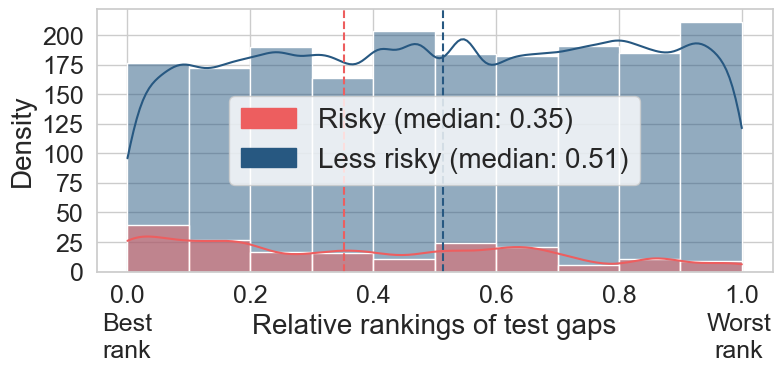

In [28]:
from SALib.sample import saltelli
from SALib.analyze import sobol

def model_scen_3(scores):
    weights = {
        'score_LEN': 0,     # used to be 1 (0-ed)
        'score_COM': 0,     # used to be 1 (0-ed)
        'score_CLI': 2,     # used to be 2
        'score_COC': 2,     # used to be 2 
        'score_ANF': 0,     # used to be 2 (0-ed)
        'score_UNF': 1,     # used to be 1
        'score_ACF': 4,     # used to be 4
        'score_UCF': 2,     # used to be 2
        'score_RCF': -2,    # used to be -2
        'score_RNF': 0,    # used to be -1 (0-ed)
        'score_CHF': 0,    # used to be -1 (0-ed)
        'score_CEN': 2      # used to be 2
    }
    
    # Calculate the risk score by summing up the score values multiplied by their respective weights
    risk_score = (
        scores[0] * weights['score_LEN'] +
        scores[1] * weights['score_COM'] +
        scores[2] * weights['score_CLI'] +
        scores[3] * weights['score_COC'] +
        scores[4] * weights['score_ANF'] +
        scores[5] * weights['score_UNF'] +
        scores[6] * weights['score_ACF'] +
        scores[7] * weights['score_UCF'] +
        scores[8] * weights['score_RCF'] +
        scores[9] * weights['score_RNF'] +
        scores[10] * weights['score_CHF'] +
        scores[11] * weights['score_CEN']
    )
    
    return risk_score

test_gaps_by_assessments = read_csv_and_get_test_gaps_scen(csv_path, model_scen_3)
scaled_risky_ranks, scaled_safe_ranks, relative_ranks_risky_gaps, relative_ranks_safe_gaps = print_stats(test_gaps_by_assessments)
draw_ranking_kdp(relative_ranks_risky_gaps,relative_ranks_safe_gaps)

--> Ranking performance remains the same when leaving out `score_LEN`, `score_COM`, `score_ANF`, `score_RNF`, `score_CHF` 

In [29]:
from SALib.sample import saltelli
from SALib.analyze import sobol

# Generate samples
samples = saltelli.sample(problem, 2039 * (12 + 2))  # following a common rule of thumb: use N x (2D + 2) model exaluations with sample size N=2039 sample and number of parameters D=12

# Run model
Y = np.array([model_scen_3(scores) for scores in samples])

# Perform Sobol sensitivity analysis
Si = sobol.analyze(problem, Y)

scen_3_s1 = Si['S1'] # First-order sensitivity indices
scen_3_sT = Si['ST'] # Total-order sensitivity indices

print(scen_3_s1)  
print(scen_3_sT)  

C:\Users\haas\AppData\Local\Temp\ipykernel_38764\2860345725.py:5: DeprecationWarning: `salib.sample.saltelli` will be removed in SALib 1.5.1 Please use `salib.sample.sobol`
  samples = saltelli.sample(problem, 2039 * (12 + 2))  # following a common rule of thumb: use N x (2D + 2) model exaluations with sample size N=2039 sample and number of parameters D=12
C:\Users\haas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\SALib\sample\saltelli.py:110: UserWarning: 
        Convergence properties of the Sobol' sequence is only valid if
        `N` (28546) is equal to `2^n`.
        
  warnings.warn(msg)
C:\Users\haas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\SALib\util\__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  n

[0.         0.         0.08176259 0.32636471 0.         0.02041402
 0.32662682 0.08162488 0.08161256 0.         0.         0.08158248]
[0.         0.         0.08163288 0.326536   0.         0.02040765
 0.3265277  0.08163427 0.08163117 0.         0.         0.08161539]


--> `score_UNF` has the lowest influence from the remaining parameters
-----> worth to remove? -> Scenario 5

--> `score_COC` and `score_ACF` are still the most prominent parameters
------> which one is more important? -> Scenario 6a and 6b

## Scenario 4a: 0-ing `score_LEN`

Total number of assessments: 31
Total number of test gaps: 2039
Safe test gaps: 1858
Risky test gaps: 181


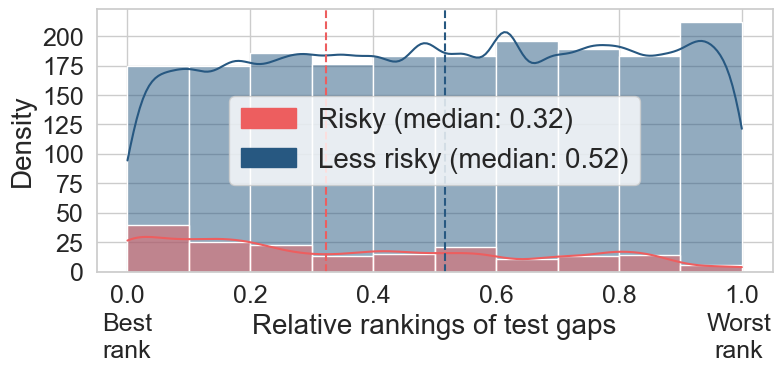

In [30]:
from SALib.sample import saltelli
from SALib.analyze import sobol

def model_scen_4a(scores):
    weights = {
        'score_LEN': 0,     # used to be 1 (0-ed)
        'score_COM': 1,     # used to be 1
        'score_CLI': 2,     # used to be 2
        'score_COC': 2,     # used to be 2 
        'score_ANF': 2,     # used to be 2 
        'score_UNF': 1,     # used to be 1
        'score_ACF': 4,     # used to be 4
        'score_UCF': 2,     # used to be 2
        'score_RCF': -2,    # used to be -2
        'score_RNF': -1,    # used to be -1
        'score_CHF': -1,    # used to be -1 
        'score_CEN': 2      # used to be 2
    }
    
    # Calculate the risk score by summing up the score values multiplied by their respective weights
    risk_score = (
        scores[0] * weights['score_LEN'] +
        scores[1] * weights['score_COM'] +
        scores[2] * weights['score_CLI'] +
        scores[3] * weights['score_COC'] +
        scores[4] * weights['score_ANF'] +
        scores[5] * weights['score_UNF'] +
        scores[6] * weights['score_ACF'] +
        scores[7] * weights['score_UCF'] +
        scores[8] * weights['score_RCF'] +
        scores[9] * weights['score_RNF'] +
        scores[10] * weights['score_CHF'] +
        scores[11] * weights['score_CEN']
    )
    
    return risk_score

test_gaps_by_assessments = read_csv_and_get_test_gaps_scen(csv_path, model_scen_4a)
scaled_risky_ranks, scaled_safe_ranks, relative_ranks_risky_gaps, relative_ranks_safe_gaps = print_stats(test_gaps_by_assessments)
draw_ranking_kdp(relative_ranks_risky_gaps,relative_ranks_safe_gaps)

--> removing LEN improves ranking performance

## Scenario 4b: 0-ing `score_COM`

Total number of assessments: 31
Total number of test gaps: 2039
Safe test gaps: 1858
Risky test gaps: 181


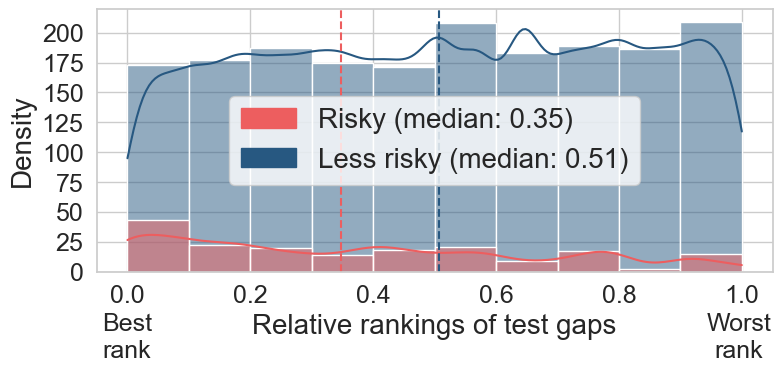

In [31]:
from SALib.sample import saltelli
from SALib.analyze import sobol

def model_scen_4b(scores):
    weights = {
        'score_LEN': 1,     # used to be 1 
        'score_COM': 0,     # used to be 1 (0-ed)
        'score_CLI': 2,     # used to be 2
        'score_COC': 2,     # used to be 2 
        'score_ANF': 2,     # used to be 2 
        'score_UNF': 1,     # used to be 1
        'score_ACF': 4,     # used to be 4
        'score_UCF': 2,     # used to be 2
        'score_RCF': -2,    # used to be -2
        'score_RNF': -1,    # used to be -1
        'score_CHF': -1,    # used to be -1 
        'score_CEN': 2      # used to be 2
    }
    
    # Calculate the risk score by summing up the score values multiplied by their respective weights
    risk_score = (
        scores[0] * weights['score_LEN'] +
        scores[1] * weights['score_COM'] +
        scores[2] * weights['score_CLI'] +
        scores[3] * weights['score_COC'] +
        scores[4] * weights['score_ANF'] +
        scores[5] * weights['score_UNF'] +
        scores[6] * weights['score_ACF'] +
        scores[7] * weights['score_UCF'] +
        scores[8] * weights['score_RCF'] +
        scores[9] * weights['score_RNF'] +
        scores[10] * weights['score_CHF'] +
        scores[11] * weights['score_CEN']
    )
    
    return risk_score

test_gaps_by_assessments = read_csv_and_get_test_gaps_scen(csv_path, model_scen_4b)
scaled_risky_ranks, scaled_safe_ranks, relative_ranks_risky_gaps, relative_ranks_safe_gaps = print_stats(test_gaps_by_assessments)
draw_ranking_kdp(relative_ranks_risky_gaps,relative_ranks_safe_gaps)

--> removing com does not influence ranking performance

## Scenario 4c: 0-ing `score_ANF`

Total number of assessments: 31
Total number of test gaps: 2039
Safe test gaps: 1858
Risky test gaps: 181


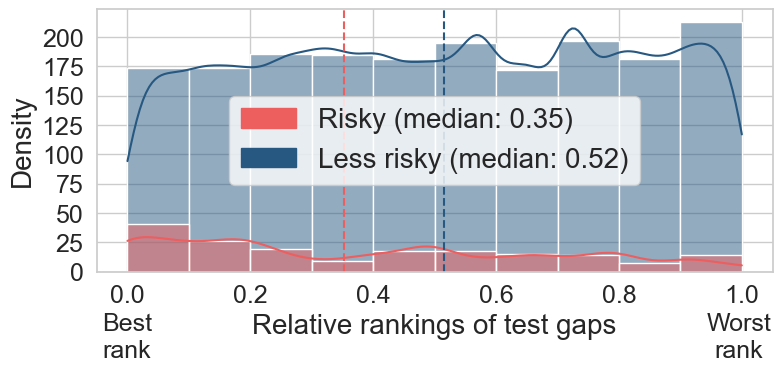

In [32]:
from SALib.sample import saltelli
from SALib.analyze import sobol

def model_scen_4c(scores):
    weights = {
        'score_LEN': 1,     # used to be 1 
        'score_COM': 1,     # used to be 1
        'score_CLI': 2,     # used to be 2
        'score_COC': 2,     # used to be 2 
        'score_ANF': 0,     # used to be 2 (0-ed)
        'score_UNF': 1,     # used to be 1
        'score_ACF': 4,     # used to be 4
        'score_UCF': 2,     # used to be 2
        'score_RCF': -2,    # used to be -2
        'score_RNF': -1,    # used to be -1
        'score_CHF': -1,    # used to be -1 
        'score_CEN': 2      # used to be 2
    }
    
    # Calculate the risk score by summing up the score values multiplied by their respective weights
    risk_score = (
        scores[0] * weights['score_LEN'] +
        scores[1] * weights['score_COM'] +
        scores[2] * weights['score_CLI'] +
        scores[3] * weights['score_COC'] +
        scores[4] * weights['score_ANF'] +
        scores[5] * weights['score_UNF'] +
        scores[6] * weights['score_ACF'] +
        scores[7] * weights['score_UCF'] +
        scores[8] * weights['score_RCF'] +
        scores[9] * weights['score_RNF'] +
        scores[10] * weights['score_CHF'] +
        scores[11] * weights['score_CEN']
    )
    
    return risk_score

test_gaps_by_assessments = read_csv_and_get_test_gaps_scen(csv_path, model_scen_4c)
scaled_risky_ranks, scaled_safe_ranks, relative_ranks_risky_gaps, relative_ranks_safe_gaps = print_stats(test_gaps_by_assessments)
draw_ranking_kdp(relative_ranks_risky_gaps,relative_ranks_safe_gaps)

--> removing anf does not influence ranking performance

## Scenario 4d: 0-ing `score_RNF`

Total number of assessments: 31
Total number of test gaps: 2039
Safe test gaps: 1858
Risky test gaps: 181


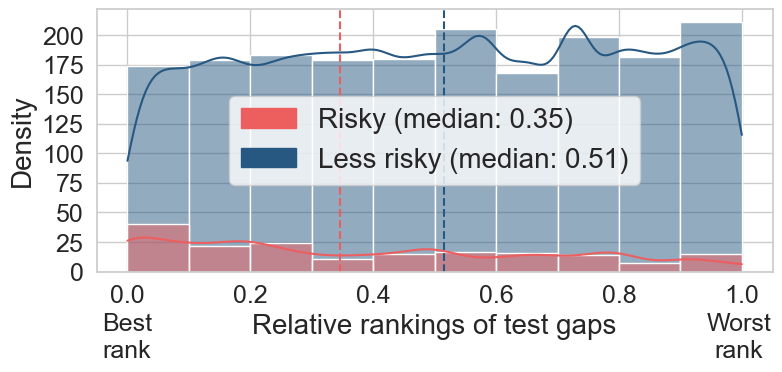

In [33]:
from SALib.sample import saltelli
from SALib.analyze import sobol

def model_scen_4d(scores):
    weights = {
        'score_LEN': 1,     # used to be 1 
        'score_COM': 1,     # used to be 1
        'score_CLI': 2,     # used to be 2
        'score_COC': 2,     # used to be 2 
        'score_ANF': 2,     # used to be 2
        'score_UNF': 1,     # used to be 1
        'score_ACF': 4,     # used to be 4
        'score_UCF': 2,     # used to be 2
        'score_RCF': -2,    # used to be -2
        'score_RNF': 0,    # used to be -1 (0-ed)
        'score_CHF': -1,    # used to be -1 
        'score_CEN': 2      # used to be 2
    }
    
    # Calculate the risk score by summing up the score values multiplied by their respective weights
    risk_score = (
        scores[0] * weights['score_LEN'] +
        scores[1] * weights['score_COM'] +
        scores[2] * weights['score_CLI'] +
        scores[3] * weights['score_COC'] +
        scores[4] * weights['score_ANF'] +
        scores[5] * weights['score_UNF'] +
        scores[6] * weights['score_ACF'] +
        scores[7] * weights['score_UCF'] +
        scores[8] * weights['score_RCF'] +
        scores[9] * weights['score_RNF'] +
        scores[10] * weights['score_CHF'] +
        scores[11] * weights['score_CEN']
    )
    
    return risk_score

test_gaps_by_assessments = read_csv_and_get_test_gaps_scen(csv_path, model_scen_4d)
scaled_risky_ranks, scaled_safe_ranks, relative_ranks_risky_gaps, relative_ranks_safe_gaps = print_stats(test_gaps_by_assessments)
draw_ranking_kdp(relative_ranks_risky_gaps,relative_ranks_safe_gaps)

--> removing rnf does not influence ranking performance

## Scenario 4e: 0-ing `score_CHF`

Total number of assessments: 31
Total number of test gaps: 2039
Safe test gaps: 1858
Risky test gaps: 181


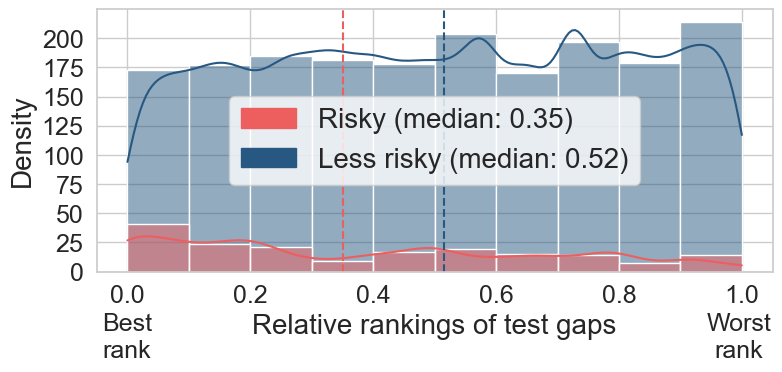

In [34]:
from SALib.sample import saltelli
from SALib.analyze import sobol

def model_scen_4e(scores):
    weights = {
        'score_LEN': 1,     # used to be 1 
        'score_COM': 1,     # used to be 1
        'score_CLI': 2,     # used to be 2
        'score_COC': 2,     # used to be 2 
        'score_ANF': 2,     # used to be 2
        'score_UNF': 1,     # used to be 1
        'score_ACF': 4,     # used to be 4
        'score_UCF': 2,     # used to be 2
        'score_RCF': -2,    # used to be -2
        'score_RNF': -1,    # used to be -1
        'score_CHF': 0,    # used to be -1 (0-ed)
        'score_CEN': 2      # used to be 2
    }
    
    # Calculate the risk score by summing up the score values multiplied by their respective weights
    risk_score = (
        scores[0] * weights['score_LEN'] +
        scores[1] * weights['score_COM'] +
        scores[2] * weights['score_CLI'] +
        scores[3] * weights['score_COC'] +
        scores[4] * weights['score_ANF'] +
        scores[5] * weights['score_UNF'] +
        scores[6] * weights['score_ACF'] +
        scores[7] * weights['score_UCF'] +
        scores[8] * weights['score_RCF'] +
        scores[9] * weights['score_RNF'] +
        scores[10] * weights['score_CHF'] +
        scores[11] * weights['score_CEN']
    )
    
    return risk_score

test_gaps_by_assessments = read_csv_and_get_test_gaps_scen(csv_path, model_scen_4e)
scaled_risky_ranks, scaled_safe_ranks, relative_ranks_risky_gaps, relative_ranks_safe_gaps = print_stats(test_gaps_by_assessments)
draw_ranking_kdp(relative_ranks_risky_gaps,relative_ranks_safe_gaps)

--> The feature `score_LEN` appears to have negative impact on the model performance, `score_COM`, `score_ANF`, `score_RNF`, and `score_CHF` do not contribute significantly.

## Scenario 5: Scenario 3 + 0-ing `score_UNF`

Total number of assessments: 31
Total number of test gaps: 2039
Safe test gaps: 1858
Risky test gaps: 181


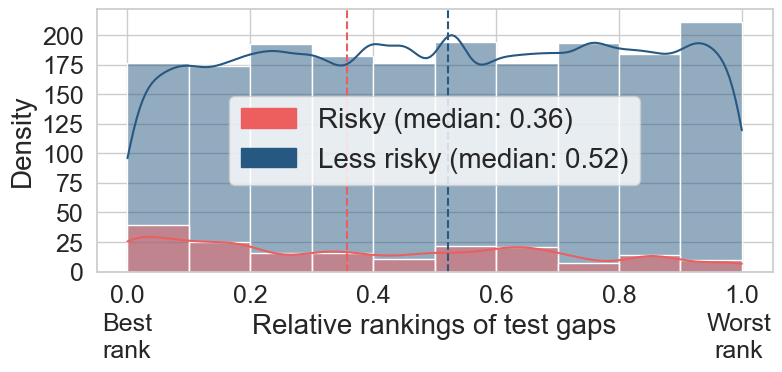

In [35]:
from SALib.sample import saltelli
from SALib.analyze import sobol

def model_scen_5(scores):
    weights = {
        'score_LEN': 0,     # used to be 1 (0-ed)
        'score_COM': 0,     # used to be 1 (0-ed)
        'score_CLI': 2,     # used to be 2
        'score_COC': 2,     # used to be 2 
        'score_ANF': 0,     # used to be 2 (0-ed)
        'score_UNF': 0,     # used to be 1 (also 0-ed)
        'score_ACF': 4,     # used to be 4
        'score_UCF': 2,     # used to be 2
        'score_RCF': -2,    # used to be -2
        'score_RNF': 0,    # used to be -1 (0-ed)
        'score_CHF': 0,    # used to be -1 (0-ed)
        'score_CEN': 2      # used to be 2
    }
    
    # Calculate the risk score by summing up the score values multiplied by their respective weights
    risk_score = (
        scores[0] * weights['score_LEN'] +
        scores[1] * weights['score_COM'] +
        scores[2] * weights['score_CLI'] +
        scores[3] * weights['score_COC'] +
        scores[4] * weights['score_ANF'] +
        scores[5] * weights['score_UNF'] +
        scores[6] * weights['score_ACF'] +
        scores[7] * weights['score_UCF'] +
        scores[8] * weights['score_RCF'] +
        scores[9] * weights['score_RNF'] +
        scores[10] * weights['score_CHF'] +
        scores[11] * weights['score_CEN']
    )
    
    return risk_score

test_gaps_by_assessments = read_csv_and_get_test_gaps_scen(csv_path, model_scen_5)
scaled_risky_ranks, scaled_safe_ranks, relative_ranks_risky_gaps, relative_ranks_safe_gaps = print_stats(test_gaps_by_assessments)
draw_ranking_kdp(relative_ranks_risky_gaps,relative_ranks_safe_gaps)

--> Performance dropped, so: No, `score_UNF` is relevant

## Scenario 6a: Scenario 3 + Increase weight for `score_COC`

Total number of assessments: 31
Total number of test gaps: 2039
Safe test gaps: 1858
Risky test gaps: 181


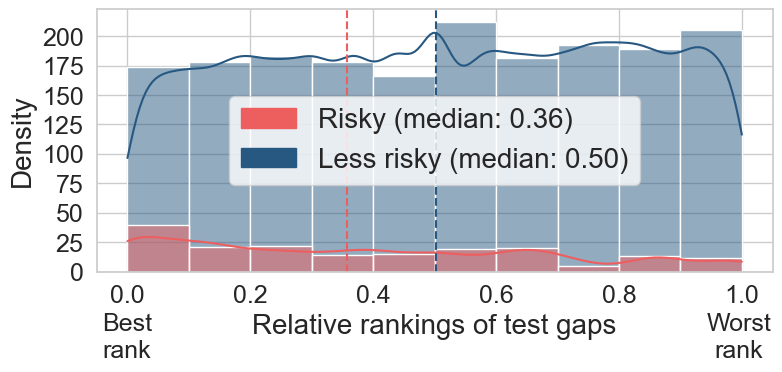

In [36]:
from SALib.sample import saltelli
from SALib.analyze import sobol

def model_scen_6a(scores):
    weights = {
        'score_LEN': 0,     # used to be 1 (0-ed)
        'score_COM': 0,     # used to be 1 (0-ed)
        'score_CLI': 2,     # used to be 2
        'score_COC': 4,     # used to be 2 (doubled)
        'score_ANF': 0,     # used to be 2 (0-ed)
        'score_UNF': 1,     # used to be 1
        'score_ACF': 4,     # used to be 4
        'score_UCF': 2,     # used to be 2
        'score_RCF': -2,    # used to be -2
        'score_RNF': 0,    # used to be -1 (0-ed)
        'score_CHF': 0,    # used to be -1 (0-ed)
        'score_CEN': 2      # used to be 2
    }
    
    # Calculate the risk score by summing up the score values multiplied by their respective weights
    risk_score = (
        scores[0] * weights['score_LEN'] +
        scores[1] * weights['score_COM'] +
        scores[2] * weights['score_CLI'] +
        scores[3] * weights['score_COC'] +
        scores[4] * weights['score_ANF'] +
        scores[5] * weights['score_UNF'] +
        scores[6] * weights['score_ACF'] +
        scores[7] * weights['score_UCF'] +
        scores[8] * weights['score_RCF'] +
        scores[9] * weights['score_RNF'] +
        scores[10] * weights['score_CHF'] +
        scores[11] * weights['score_CEN']
    )
    
    return risk_score

test_gaps_by_assessments = read_csv_and_get_test_gaps_scen(csv_path, model_scen_6a)
scaled_risky_ranks, scaled_safe_ranks, relative_ranks_risky_gaps, relative_ranks_safe_gaps = print_stats(test_gaps_by_assessments)
draw_ranking_kdp(relative_ranks_risky_gaps,relative_ranks_safe_gaps)

--> Lowered ranking performance

## Scenario 6b: Scenario 3 + Increase weight for `score_ACF`

Total number of assessments: 31
Total number of test gaps: 2039
Safe test gaps: 1858
Risky test gaps: 181


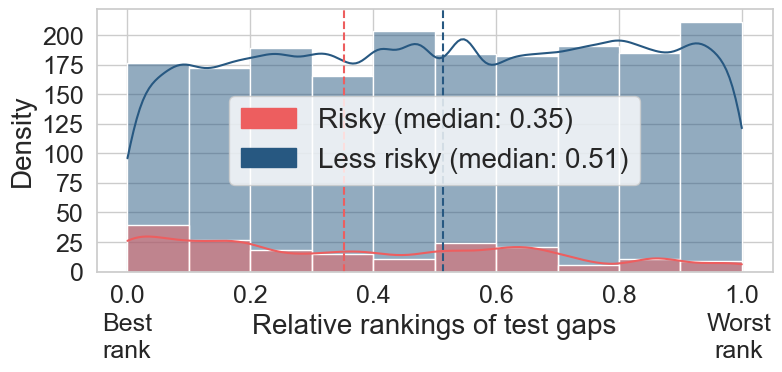

In [37]:
from SALib.sample import saltelli
from SALib.analyze import sobol

def model_scen_6b(scores):
    weights = {
        'score_LEN': 0,     # used to be 1 (0-ed)
        'score_COM': 0,     # used to be 1 (0-ed)
        'score_CLI': 2,     # used to be 2
        'score_COC': 2,     # used to be 2
        'score_ANF': 0,     # used to be 2 (0-ed)
        'score_UNF': 1,     # used to be 1
        'score_ACF': 8,     # used to be 4 (doubled)
        'score_UCF': 2,     # used to be 2
        'score_RCF': -2,    # used to be -2
        'score_RNF': 0,    # used to be -1 (0-ed)
        'score_CHF': 0,    # used to be -1 (0-ed)
        'score_CEN': 2      # used to be 2
    }
    
    # Calculate the risk score by summing up the score values multiplied by their respective weights
    risk_score = (
        scores[0] * weights['score_LEN'] +
        scores[1] * weights['score_COM'] +
        scores[2] * weights['score_CLI'] +
        scores[3] * weights['score_COC'] +
        scores[4] * weights['score_ANF'] +
        scores[5] * weights['score_UNF'] +
        scores[6] * weights['score_ACF'] +
        scores[7] * weights['score_UCF'] +
        scores[8] * weights['score_RCF'] +
        scores[9] * weights['score_RNF'] +
        scores[10] * weights['score_CHF'] +
        scores[11] * weights['score_CEN']
    )
    
    return risk_score

test_gaps_by_assessments = read_csv_and_get_test_gaps_scen(csv_path, model_scen_6b)
scaled_risky_ranks, scaled_safe_ranks, relative_ranks_risky_gaps, relative_ranks_safe_gaps = print_stats(test_gaps_by_assessments)
draw_ranking_kdp(relative_ranks_risky_gaps,relative_ranks_safe_gaps)

--> Ranking performance stays at 0.35

## Scenario 7: Scenario 2 + 0-ing weight for `score_LEN`

Total number of assessments: 31
Total number of test gaps: 2039
Safe test gaps: 1858
Risky test gaps: 181


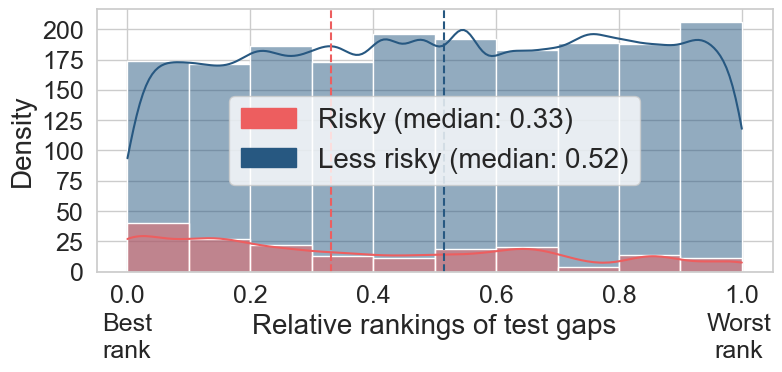

In [38]:
from SALib.sample import saltelli
from SALib.analyze import sobol

def model_scen_7(scores):
    weights = {
        'score_LEN': 0,     # used to be 1 (0-ed)
        'score_COM': 1,     # used to be 1
        'score_CLI': 2,     # used to be 2
        'score_COC': 4,     # used to be 2 (doubled)
        'score_ANF': 2,     # used to be 2
        'score_UNF': 1,     # used to be 1
        'score_ACF': 8,     # used to be 4 (doubled)
        'score_UCF': 2,     # used to be 2
        'score_RCF': -2,    # used to be -2
        'score_RNF': -1,    # used to be -1
        'score_CHF': -1,    # used to be -1
        'score_CEN': 2      # used to be 2
    }
    
    # Calculate the risk score by summing up the score values multiplied by their respective weights
    risk_score = (
        scores[0] * weights['score_LEN'] +
        scores[1] * weights['score_COM'] +
        scores[2] * weights['score_CLI'] +
        scores[3] * weights['score_COC'] +
        scores[4] * weights['score_ANF'] +
        scores[5] * weights['score_UNF'] +
        scores[6] * weights['score_ACF'] +
        scores[7] * weights['score_UCF'] +
        scores[8] * weights['score_RCF'] +
        scores[9] * weights['score_RNF'] +
        scores[10] * weights['score_CHF'] +
        scores[11] * weights['score_CEN']
    )
    
    return risk_score

test_gaps_by_assessments = read_csv_and_get_test_gaps_scen(csv_path, model_scen_7)
scaled_risky_ranks, scaled_safe_ranks, relative_ranks_risky_gaps, relative_ranks_safe_gaps = print_stats(test_gaps_by_assessments)
draw_ranking_kdp(relative_ranks_risky_gaps,relative_ranks_safe_gaps)